In [1]:
import torch
import torch.nn as nn
import torch.optim as optim 
import numpy as np
from walidacja_funkcji import *

In [2]:
GENERATOR_SAMPLES_TO_RETURN = 768
BATCH_SIZE = 128

prober = rs_prober_NKG(epsilon=0.1, looking_x_left=-1, looking_x_right=1, from_x=0)

def get_2d_data(PROBE_SIZE: int):
    rs = prober.rejection_sampling(length=PROBE_SIZE // 2)
    theta = np.random.uniform(0, 2*np.pi, size=PROBE_SIZE // 2)
    xs = rs * np.cos(theta)
    ys = rs * np.sin(theta)
    return np.vstack([xs, ys])

In [58]:
class CouplingLayer(nn.Module):
    """A single coupling layer combining scale and translation networks"""
    def __init__(self, input_dim):
        super(CouplingLayer, self).__init__()
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, input_dim)
        )
        
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, input_dim),
            nn.Tanh()  # Constrain output to [-1, 1]
        )
        
        self.scale_factor = nn.Parameter(torch.ones(1) * 0.1)
    
    def forward(self, x):
        return self.translate_net(x), self.scale_net(x) * self.scale_factor

class NormalizingFlows(nn.Module):
    def __init__(self, input_dim, num_coupling_layers, lr=1e-3):
        super(NormalizingFlows, self).__init__()
        self.coupling_layers = nn.ModuleList([
            CouplingLayer(input_dim) for _ in range(num_coupling_layers)
        ])
        self.optim = optim.Adam(self.parameters(), lr)

    def check_if_size_is_odd(self, vector):
        if vector.size(-1) % 2 == 1:
            raise ValueError("input dimension is odd, make it even.")

    def forward(self, input_vector):
        layer_output = input_vector.clone()
        log_det_jacobi = 0

        for i, coupling_layer in enumerate(self.coupling_layers):
            self.check_if_size_is_odd(layer_output)
            div_indx = layer_output.size(-1) // 2
            x = layer_output[:, :, :div_indx].squeeze()
            y = layer_output[:, :, div_indx:].squeeze()
            
            translate_out, scaled = coupling_layer(x)
            
            # Debug information
            if torch.any(torch.abs(scaled) > 5):
                print(f"Layer {i}: Found large scaled values")
                print(f"Max scaled: {scaled.max().item()}, Min scaled: {scaled.min().item()}")
            
            # Clamp to prevent numerical issues
            scaled = torch.clamp(scaled, -5.0, 5.0)
            
            log_det_jacobi += scaled.sum(dim=-1)
            exp_scaled = torch.exp(scaled)
            
            # Apply the coupling transformation
            y = y * exp_scaled + translate_out

            # More debugging
            if torch.any(y > 1e10):
                print(f"Layer {i}: Large y values detected")
                print(f"Max y: {y.max().item()}")
                pdb.set_trace()
                raise ValueError(f'Large value detected: scaled max={scaled.max()}, translate max={translate_out.max()}')
            
            if torch.isnan(y).any():
                raise ValueError(f'NaN detected: scaled max={scaled.max()}, translate max={translate_out.max()}')
            
            layer_output = torch.stack([x, y], dim=2)

        return layer_output, log_det_jacobi

    def inverse(self, input_vector):
        layer_output = input_vector.clone()
        
        for coupling_layer in reversed(self.coupling_layers):
            self.check_if_size_is_odd(layer_output)
            div_indx = layer_output.size(-1) // 2
            x = layer_output[:, :, :div_indx].squeeze()
            y = layer_output[:, :, div_indx:].squeeze()
            
            # Get translation and scale for the inverse
            translate_out, scaled = coupling_layer(x)
            
            # Apply inverse coupling transformation
            y = (y - translate_out) * torch.exp(-scaled)
            
            layer_output = torch.stack([x, y], dim=2)

        return layer_output

    def training_step(self, batched_vector):
        self.zero_grad()
        
        output, log_det_jacobi = self.forward(batched_vector)
        loss = -log_det_jacobi.mean()
        
        # If you have a base distribution (e.g., Gaussian), add its log prob
        # For example: loss += -normal_log_prob(output).mean()
        
        loss.backward()
        self.optim.step()

        return loss.item()

size = GENERATOR_SAMPLES_TO_RETURN // 2
num_coupling_layers = 3

# Create the normalizing flow model with proper coupling layers
coupling_layers = NormalizingFlows(input_dim=size, num_coupling_layers=num_coupling_layers, lr=1e-3)

EPOCHS = 100
loss_history = np.empty(EPOCHS)

for epoch in range(EPOCHS):
    if epoch % 10 == 0:
        print(f'\r{epoch=}', end='', flush=True)
        
    vector_input = get_2d_data(PROBE_SIZE=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN).T
    vector_input = torch.Tensor(vector_input)
    vector_input = vector_input.reshape(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN // 2, 2)
    loss_history[epoch] = coupling_layers.training_step(vector_input)

epoch=90

In [68]:
xs, ys = get_2d_data(PROBE_SIZE=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN)
xs, ys = torch.Tensor(xs), torch.Tensor(ys)
vector_input = get_2d_data(PROBE_SIZE=BATCH_SIZE * GENERATOR_SAMPLES_TO_RETURN).T
vector_input = torch.Tensor(vector_input)
vector_input = vector_input.reshape(BATCH_SIZE, GENERATOR_SAMPLES_TO_RETURN // 2, 2) 
output, _ = coupling_layers.forward( vector_input )
inversed = coupling_layers.inverse( output )

Text(0, 0.5, 'strata')

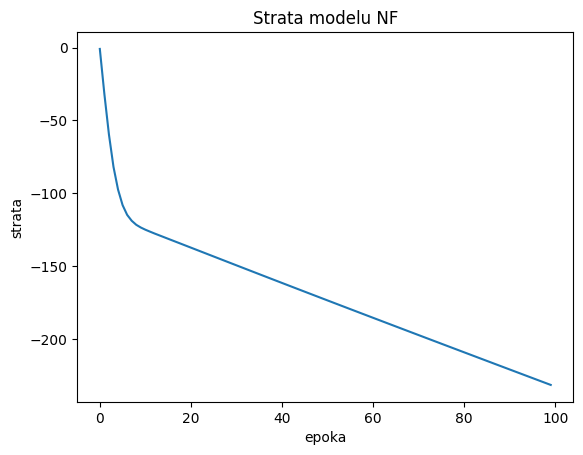

In [69]:
plt.title('Strata modelu NF')
plt.plot(loss_history)
plt.xlabel('epoka')
plt.ylabel('strata')

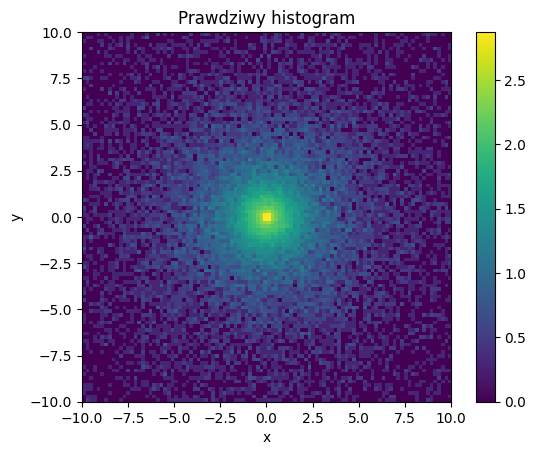

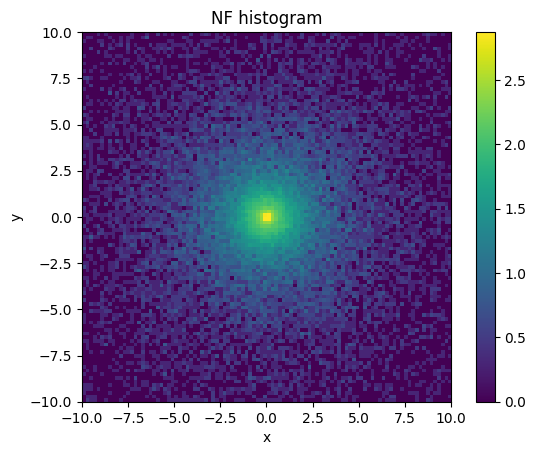

In [88]:
inversed_histogram, x_edges, y_edges = np.histogram2d(inversed[:, 0], inversed[:, 1], range=[[-10, 10], [-10, 10]], bins=100)
true_histogram, x_true_edges, y_true_edges = np.histogram2d(vector_input.reshape(-1, 2)[:, 0], vector_input.reshape(-1, 2)[:, 1], range=[[-10, 10], [-10, 10]], bins=100)

plt.title('Prawdziwy histogram')
plt.imshow(np.log10(true_histogram + 1), extent=(x_true_edges.min(), x_true_edges.max(), y_true_edges.min(), y_true_edges.max()))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

plt.title('NF histogram')
plt.imshow(np.log10(inversed_histogram + 1), extent=(x_true_edges.min(), x_true_edges.max(), y_true_edges.min(), y_true_edges.max()))
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

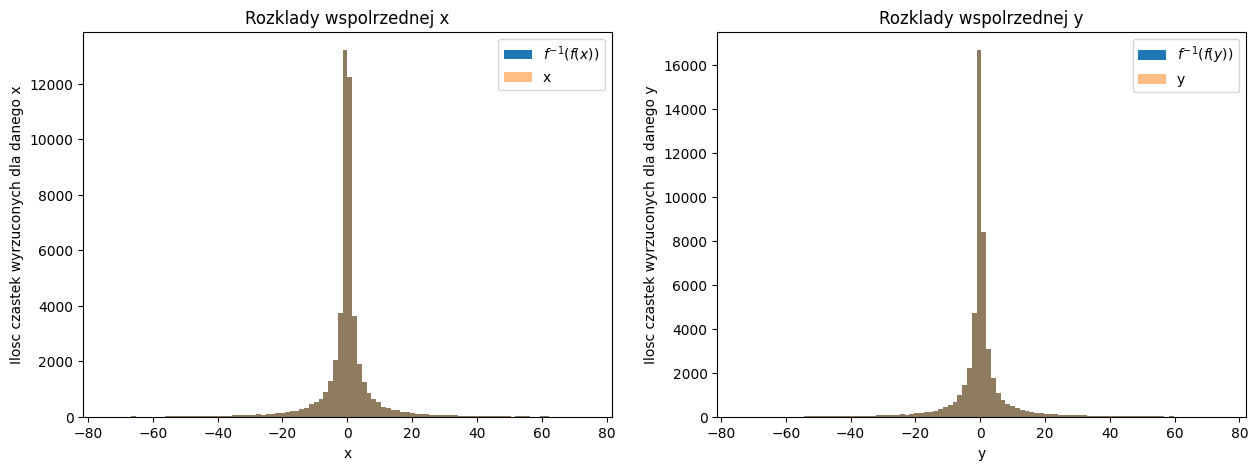

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1.set_title('Rozklady wspolrzednej x')
x_invr, _, _ = ax1.hist(inversed[:, 0], label=r'$f^{-1}(f(x))$', bins=100)
x_true, _, _ = ax1.hist(vector_input.reshape(-1, 2)[:, 0], label=r'x', bins=100, alpha=0.5)
ax1.set_ylabel('Ilosc czastek wyrzuconych dla danego x')
ax1.set_xlabel('x')
ax1.legend()

ax2.set_title('Rozklady wspolrzednej y')
y_invr, _, _ = ax2.hist(inversed[:, 1], label=r'$f^{-1}(f(y))$', bins=100)
y_true, _, _ = ax2.hist(vector_input.reshape(-1, 2)[:, 1], label=r'y', bins=100, alpha=0.5)
ax2.set_ylabel('Ilosc czastek wyrzuconych dla danego y')
ax2.set_xlabel('y')
ax2.legend()

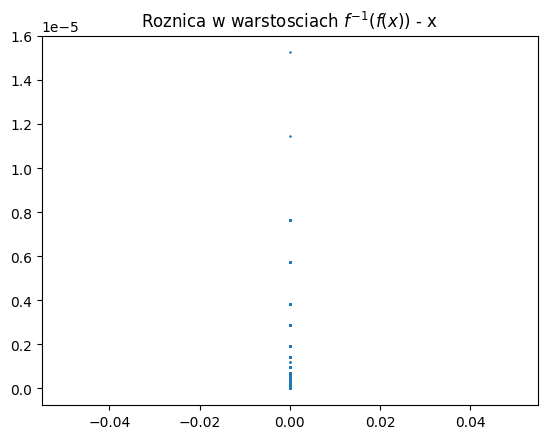

In [135]:
# vector_input = vector_input.reshape(-1, 2).detach().numpy()
error = np.abs(vector_input - inversed)

plt.title(r'Roznica w warstosciach $f^{-1}(f(x))$ - x')
plt.scatter(error[:, 0], error[:, 1], s=0.3)